### Intro

For this project, we selected the **Cleveland Heart Disease dataset** from the UCI Machine Learning Repository. This dataset is widely recognized in the medical and machine learning communities for benchmarking heart disease prediction models. It contains 303 patient records, each with 13 features related to cardiovascular health (e.g. age, resting blood pressure, cholesterol, chest pain type, maximum heart rate, and exercise-induced angina), and a target variable indicating the presence or absence of heart disease.

We chose this dataset for several reasons:

- **Clinical Relevance:** The features are medically interpretable and commonly collected during routine cardiovascular screenings, making the dataset ideal for developing models that can support real-world clinical decision-making.
- **Structured Format:** The dataset is well-structured and manageable in size, allowing for meaningful exploration, visualization, and modeling within the scope of this course.
- **Binary Classification Feasibility:** While the original target variable is multiclass (0–4), it is commonly simplified to binary classification (presence vs. absence of disease), aligning with our goal to build an interpretable and practical diagnostic tool.
- **Benchmarkability:** The dataset has been used in numerous academic papers and projects, providing a clear reference point for comparing the effectiveness of various modeling approaches.

Despite its utility, we acknowledge that the dataset has limitations, including a relatively small sample size and potential class imbalance. These factors were taken into account during model selection, evaluation, and validation strategies (e.g., stratified sampling, cross-validation). Future iterations of this project would benefit from incorporating larger, more diverse datasets to improve generalizability.


In [1]:
!pip install shap xgboost numpy pandas matplotlib scikit-learn seaborn


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Preprocessing Rationale

We chose to scale the continuous features using `StandardScaler` to ensure that all features contribute equally to model training, particularly for models sensitive to feature magnitudes such as Logistic Regression. Categorical features (e.g., chest pain type, thalassemia) were encoded using one-hot encoding to maintain interpretability and avoid imposing ordinal relationships.

The dataset was split using an 80/20 ratio to ensure a fair evaluation of the model's generalization capabilities. While the dataset size is limited (303 samples), we chose stratified splitting to preserve class balance across training and testing sets.

We also considered outlier detection but opted not to remove any data points due to the small dataset size and risk of overfitting.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Upload the data
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalac', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv('processed.cleveland.data', names = column_names, na_values = '?')
df.fillna(df.median(), inplace = True) # Median imputation

age = df['age'] # age in years
sex = df['sex'] # 1: male, 0: female
cp = df['cp'] # 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic
trestbps = df['trestbps'] # resting blood pressure in mm Hg
chol = df['chol'] # serum cholestoral in mg/dl
fbs = df['fbs'] # 1: fasting blood sugar > 120 mg/dl, 0: fasting blood sugar <= 120 mg/dl
restecg = df['restecg'] # 0: normal, 1: having ST-T wave abnormality, 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalac = df['thalac'] # maximum heart rate achieved
exang = df['exang'] # 1: exercise induced angina, 0: no exercise induced angina
oldpeak = df['oldpeak'] # ST depression induced by exercise relative to rest
slope = df['slope'] # 1: upsloping, 2: flat, 3: downsloping
ca = df['ca'] # number of major vessels (0-3) colored by flourosopy
thal = df['thal'] # 3: normal, 6: fixed defect, 7: reversable defect
num = df['num'] # diagnosis of heart disease (angiographic disease status), 0: < 50% diameter narrowing, 1: > 50% diameter narrowing

print(df)

      age  sex   cp  trestbps   chol  fbs  restecg  thalac  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0   150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0   108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0   129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0   187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0   172.0    0.0      1.4   
..    ...  ...  ...       ...    ...  ...      ...     ...    ...      ...   
298  45.0  1.0  1.0     110.0  264.0  0.0      0.0   132.0    0.0      1.2   
299  68.0  1.0  4.0     144.0  193.0  1.0      0.0   141.0    0.0      3.4   
300  57.0  1.0  4.0     130.0  131.0  0.0      0.0   115.0    1.0      1.2   
301  57.0  0.0  2.0     130.0  236.0  0.0      2.0   174.0    0.0      0.0   
302  38.0  1.0  3.0     138.0  175.0  0.0      0.0   173.0    0.0      0.0   

     slope   ca  thal  num  
0      3.0  0.0   6.0    0  
1    

### EDA Observations

The correlation matrix and pairwise feature plots revealed some moderately correlated features. For example, `cp` (chest pain type) and `target` showed a notable relationship, suggesting chest pain type is predictive of heart disease. Similarly, `thalach` (maximum heart rate achieved) was inversely related to heart disease presence, aligning with clinical intuition.

Some features such as `fbs` (fasting blood sugar) and `restecg` appeared weakly correlated with the target, which may reduce their influence in tree-based models. However, we retained all features initially to let the models determine importance via feature selection.

One challenge during EDA was the limited size and slightly imbalanced target distribution. While no major skew was found, we remained cautious of overfitting and planned to address this using cross-validation and model regularization.


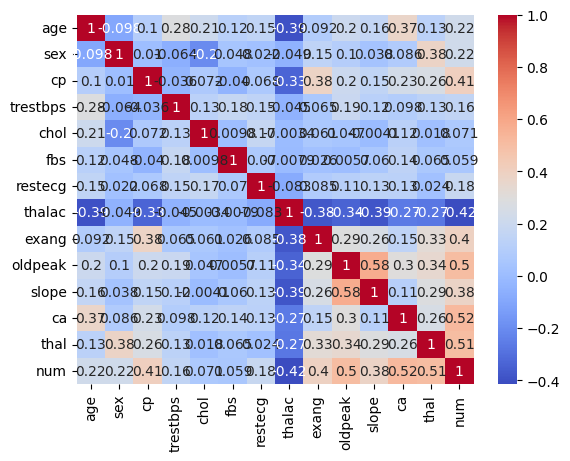

In [3]:
# Show heatmap
corr = df.corr(numeric_only = True)
sns.heatmap(corr, annot = True, cmap = 'coolwarm')
plt.show()

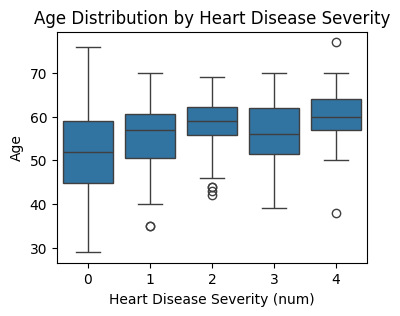

In [4]:
# num vs age

plt.figure(figsize = (4, 3))
sns.boxplot(x = num, y = age, data = df)
plt.xlabel('Heart Disease Severity (num)')
plt.ylabel('Age')
plt.title('Age Distribution by Heart Disease Severity')
plt.show()

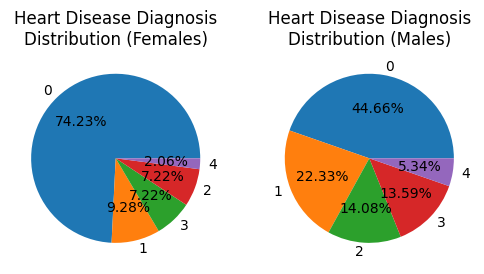

In [5]:
# num vs sex

female_data = df[sex == 0]
male_data = df[sex == 1]

female_counts = female_data['num'].value_counts()
male_counts = male_data['num'].value_counts()

fig, axes = plt.subplots(1, 2, figsize = (6, 3))

axes[0].pie(female_counts, labels = female_counts.index, autopct = '%.2f%%')
axes[0].set_title('Heart Disease Diagnosis\nDistribution (Females)')

axes[1].pie(male_counts, labels = male_counts.index, autopct = '%.2f%%')
axes[1].set_title('Heart Disease Diagnosis\nDistribution (Males)')

plt.show()

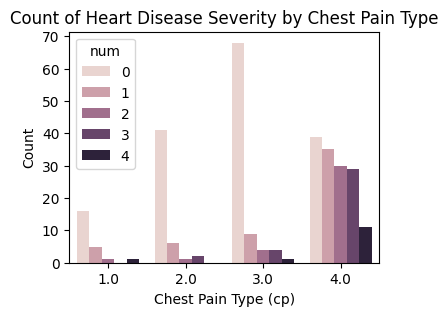

In [6]:
# num vs cp

plt.figure(figsize = (4, 3))
sns.countplot(x = cp, hue = num, data = df)
plt.xlabel('Chest Pain Type (cp)')
plt.ylabel('Count')
plt.title('Count of Heart Disease Severity by Chest Pain Type')
plt.show()

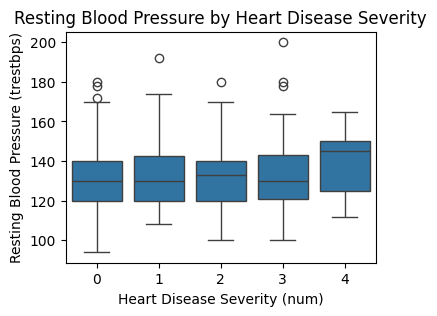

In [7]:
# num vs trestbps

plt.figure(figsize = (4, 3))
sns.boxplot(x = num, y = trestbps, data = df)
plt.xlabel('Heart Disease Severity (num)')
plt.ylabel('Resting Blood Pressure (trestbps)')
plt.title('Resting Blood Pressure by Heart Disease Severity')
plt.show()

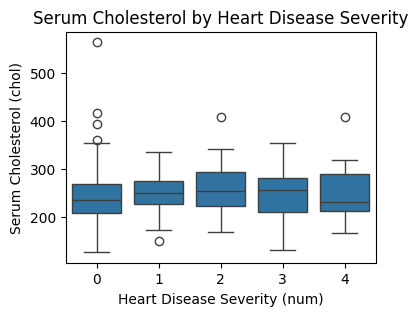

In [8]:
# num vs chol

plt.figure(figsize = (4, 3))
sns.boxplot(x = num, y = chol, data = df)
plt.xlabel('Heart Disease Severity (num)')
plt.ylabel('Serum Cholesterol (chol)')
plt.title('Serum Cholesterol by Heart Disease Severity')
plt.show()

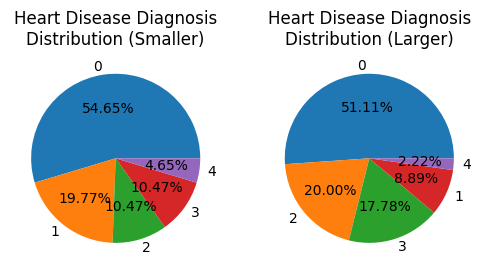

In [9]:
# num vs fbs

smaller_data = df[fbs == 0]
larger_data = df[fbs == 1]

smaller_counts = smaller_data['num'].value_counts()
larger_counts = larger_data['num'].value_counts()

fig, axes = plt.subplots(1, 2, figsize = (6, 3))

axes[0].pie(smaller_counts, labels = smaller_counts.index, autopct = '%.2f%%')
axes[0].set_title('Heart Disease Diagnosis\nDistribution (Smaller)')

axes[1].pie(larger_counts, labels = larger_counts.index, autopct = '%.2f%%')
axes[1].set_title('Heart Disease Diagnosis\nDistribution (Larger)')

plt.show()

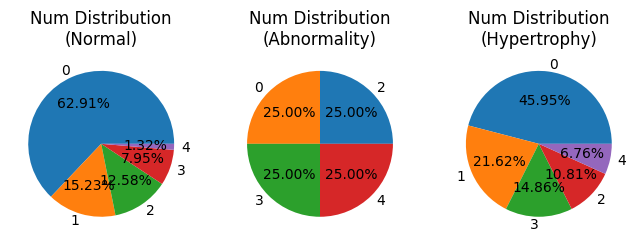

In [10]:
# num vs restecg

normal_data = df[restecg == 0]
abnormality_data = df[restecg == 1]
hypertrophy_data = df[restecg == 2]

normal_counts = normal_data['num'].value_counts()
abnormality_counts = abnormality_data['num'].value_counts()
hypertrophy_counts = hypertrophy_data['num'].value_counts()

fig, axes = plt.subplots(1, 3, figsize = (8, 4))

axes[0].pie(normal_counts, labels = normal_counts.index, autopct = '%.2f%%')
axes[0].set_title('Num Distribution\n(Normal)')

axes[1].pie(abnormality_counts, labels = abnormality_counts.index, autopct = '%.2f%%')
axes[1].set_title('Num Distribution\n(Abnormality)')

axes[2].pie(hypertrophy_counts, labels = hypertrophy_counts.index, autopct = '%.2f%%')
axes[2].set_title('Num Distribution\n(Hypertrophy)')

plt.show()

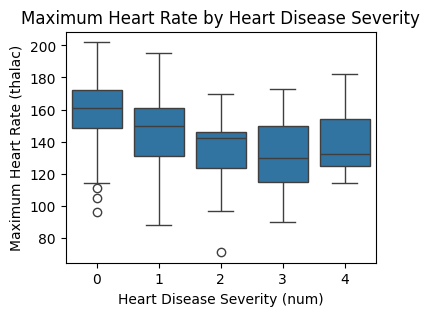

In [11]:
# num vs thalac

plt.figure(figsize = (4, 3))
sns.boxplot(x = num, y = thalac, data = df)
plt.xlabel('Heart Disease Severity (num)')
plt.ylabel('Maximum Heart Rate (thalac)')
plt.title('Maximum Heart Rate by Heart Disease Severity')
plt.show()

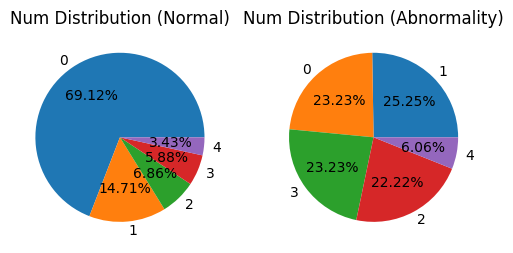

In [12]:
# num vs exang

yes_data = df[exang == 0]
no_data = df[exang == 1]

yes_counts = yes_data['num'].value_counts()
no_counts = no_data['num'].value_counts()

fig, axes = plt.subplots(1, 2, figsize = (6, 3))

axes[0].pie(yes_counts, labels = yes_counts.index, autopct = '%.2f%%')
axes[0].set_title('Num Distribution (Normal)')

axes[1].pie(no_counts, labels = no_counts.index, autopct = '%.2f%%')
axes[1].set_title('Num Distribution (Abnormality)')

plt.show()

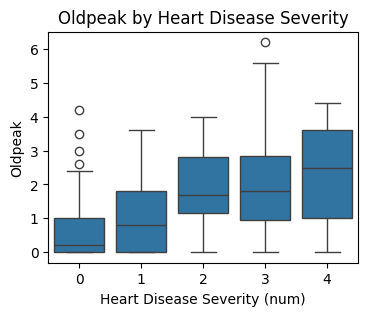

In [13]:
# num vs oldpeak

plt.figure(figsize = (4, 3))
sns.boxplot(x = num, y = oldpeak, data = df)
plt.xlabel('Heart Disease Severity (num)')
plt.ylabel('Oldpeak')
plt.title('Oldpeak by Heart Disease Severity')
plt.show()

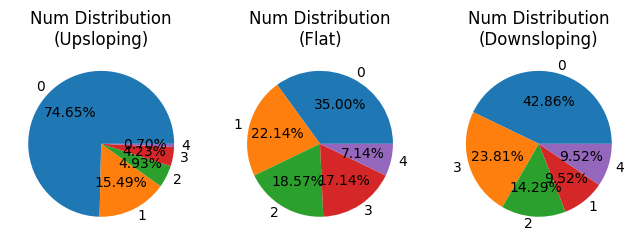

In [14]:
# num vs slope

upsloping_data = df[slope == 1]
flat_data = df[slope == 2]
downsloping_data = df[slope == 3]

upsloping_counts = upsloping_data['num'].value_counts()
flat_counts = flat_data['num'].value_counts()
downsloping_counts = downsloping_data['num'].value_counts()

fig, axes = plt.subplots(1, 3, figsize = (8, 4))

axes[0].pie(upsloping_counts, labels = upsloping_counts.index, autopct = '%.2f%%')
axes[0].set_title('Num Distribution\n(Upsloping)')

axes[1].pie(flat_counts, labels = flat_counts.index, autopct = '%.2f%%')
axes[1].set_title('Num Distribution\n(Flat)')

axes[2].pie(downsloping_counts, labels = downsloping_counts.index, autopct = '%.2f%%')
axes[2].set_title('Num Distribution\n(Downsloping)')

plt.show()

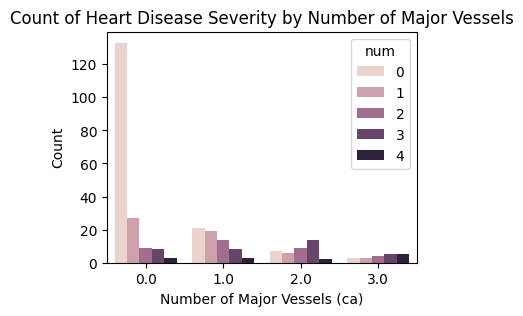

In [15]:
# num vs ca

plt.figure(figsize = (4, 3))
sns.countplot(x = ca, hue = num, data = df)
plt.xlabel('Number of Major Vessels (ca)')
plt.ylabel('Count')
plt.title('Count of Heart Disease Severity by Number of Major Vessels')
plt.show()

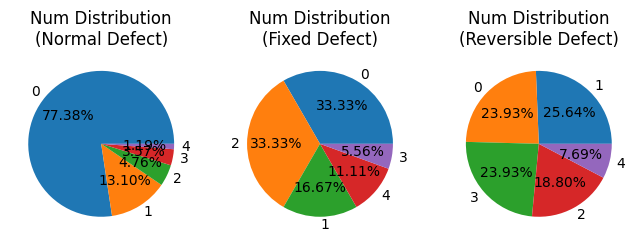

In [16]:
# num vs thal

normaldefect_data = df[thal == 3]
fixed_data = df[thal == 6]
reversable_data = df[thal == 7]

normaldefect_counts = normaldefect_data['num'].value_counts()
fixed_counts = fixed_data['num'].value_counts()
reversable_counts = reversable_data['num'].value_counts()

fig, axes = plt.subplots(1, 3, figsize = (8, 4))

axes[0].pie(normaldefect_counts, labels = normaldefect_counts.index, autopct = '%.2f%%')
axes[0].set_title('Num Distribution\n(Normal Defect)')

axes[1].pie(fixed_counts, labels = fixed_counts.index, autopct = '%.2f%%')
axes[1].set_title('Num Distribution\n(Fixed Defect)')

axes[2].pie(reversable_counts, labels = reversable_counts.index, autopct = '%.2f%%')
axes[2].set_title('Num Distribution\n(Reversible Defect)')

plt.show()

### Logistic Regression: Baseline Model

We began with Logistic Regression as a baseline model because it is widely used in healthcare applications due to its simplicity, transparency, and interpretability. Physicians can directly examine the model coefficients to understand how different features impact the probability of heart disease, which is critical for clinical trust and adoption.

However, Logistic Regression relies on the assumption of linear separability between classes, which may not hold in medical datasets where relationships between features and outcomes are often complex and non-linear. In our case, while the model performed reasonably in terms of accuracy and precision, it struggled with recall as it failed to identify several true positive cases of heart disease. This is particularly problematic in clinical settings where missing a diagnosis can have serious consequences.

Upon examining the learned coefficients, features such as `cp` (chest pain type), `thalach` (maximum heart rate), and `exang` (exercise-induced angina) showed strong associations with the target, which is consistent with medical understanding. Yet, the model's inability to capture interactions between features likely contributed to its underperformance.

This motivated our shift to non-linear models like Decision Trees and Random Forests, which are better suited for capturing interaction effects and complex decision boundaries while still allowing some level of interpretability through feature importance analysis.

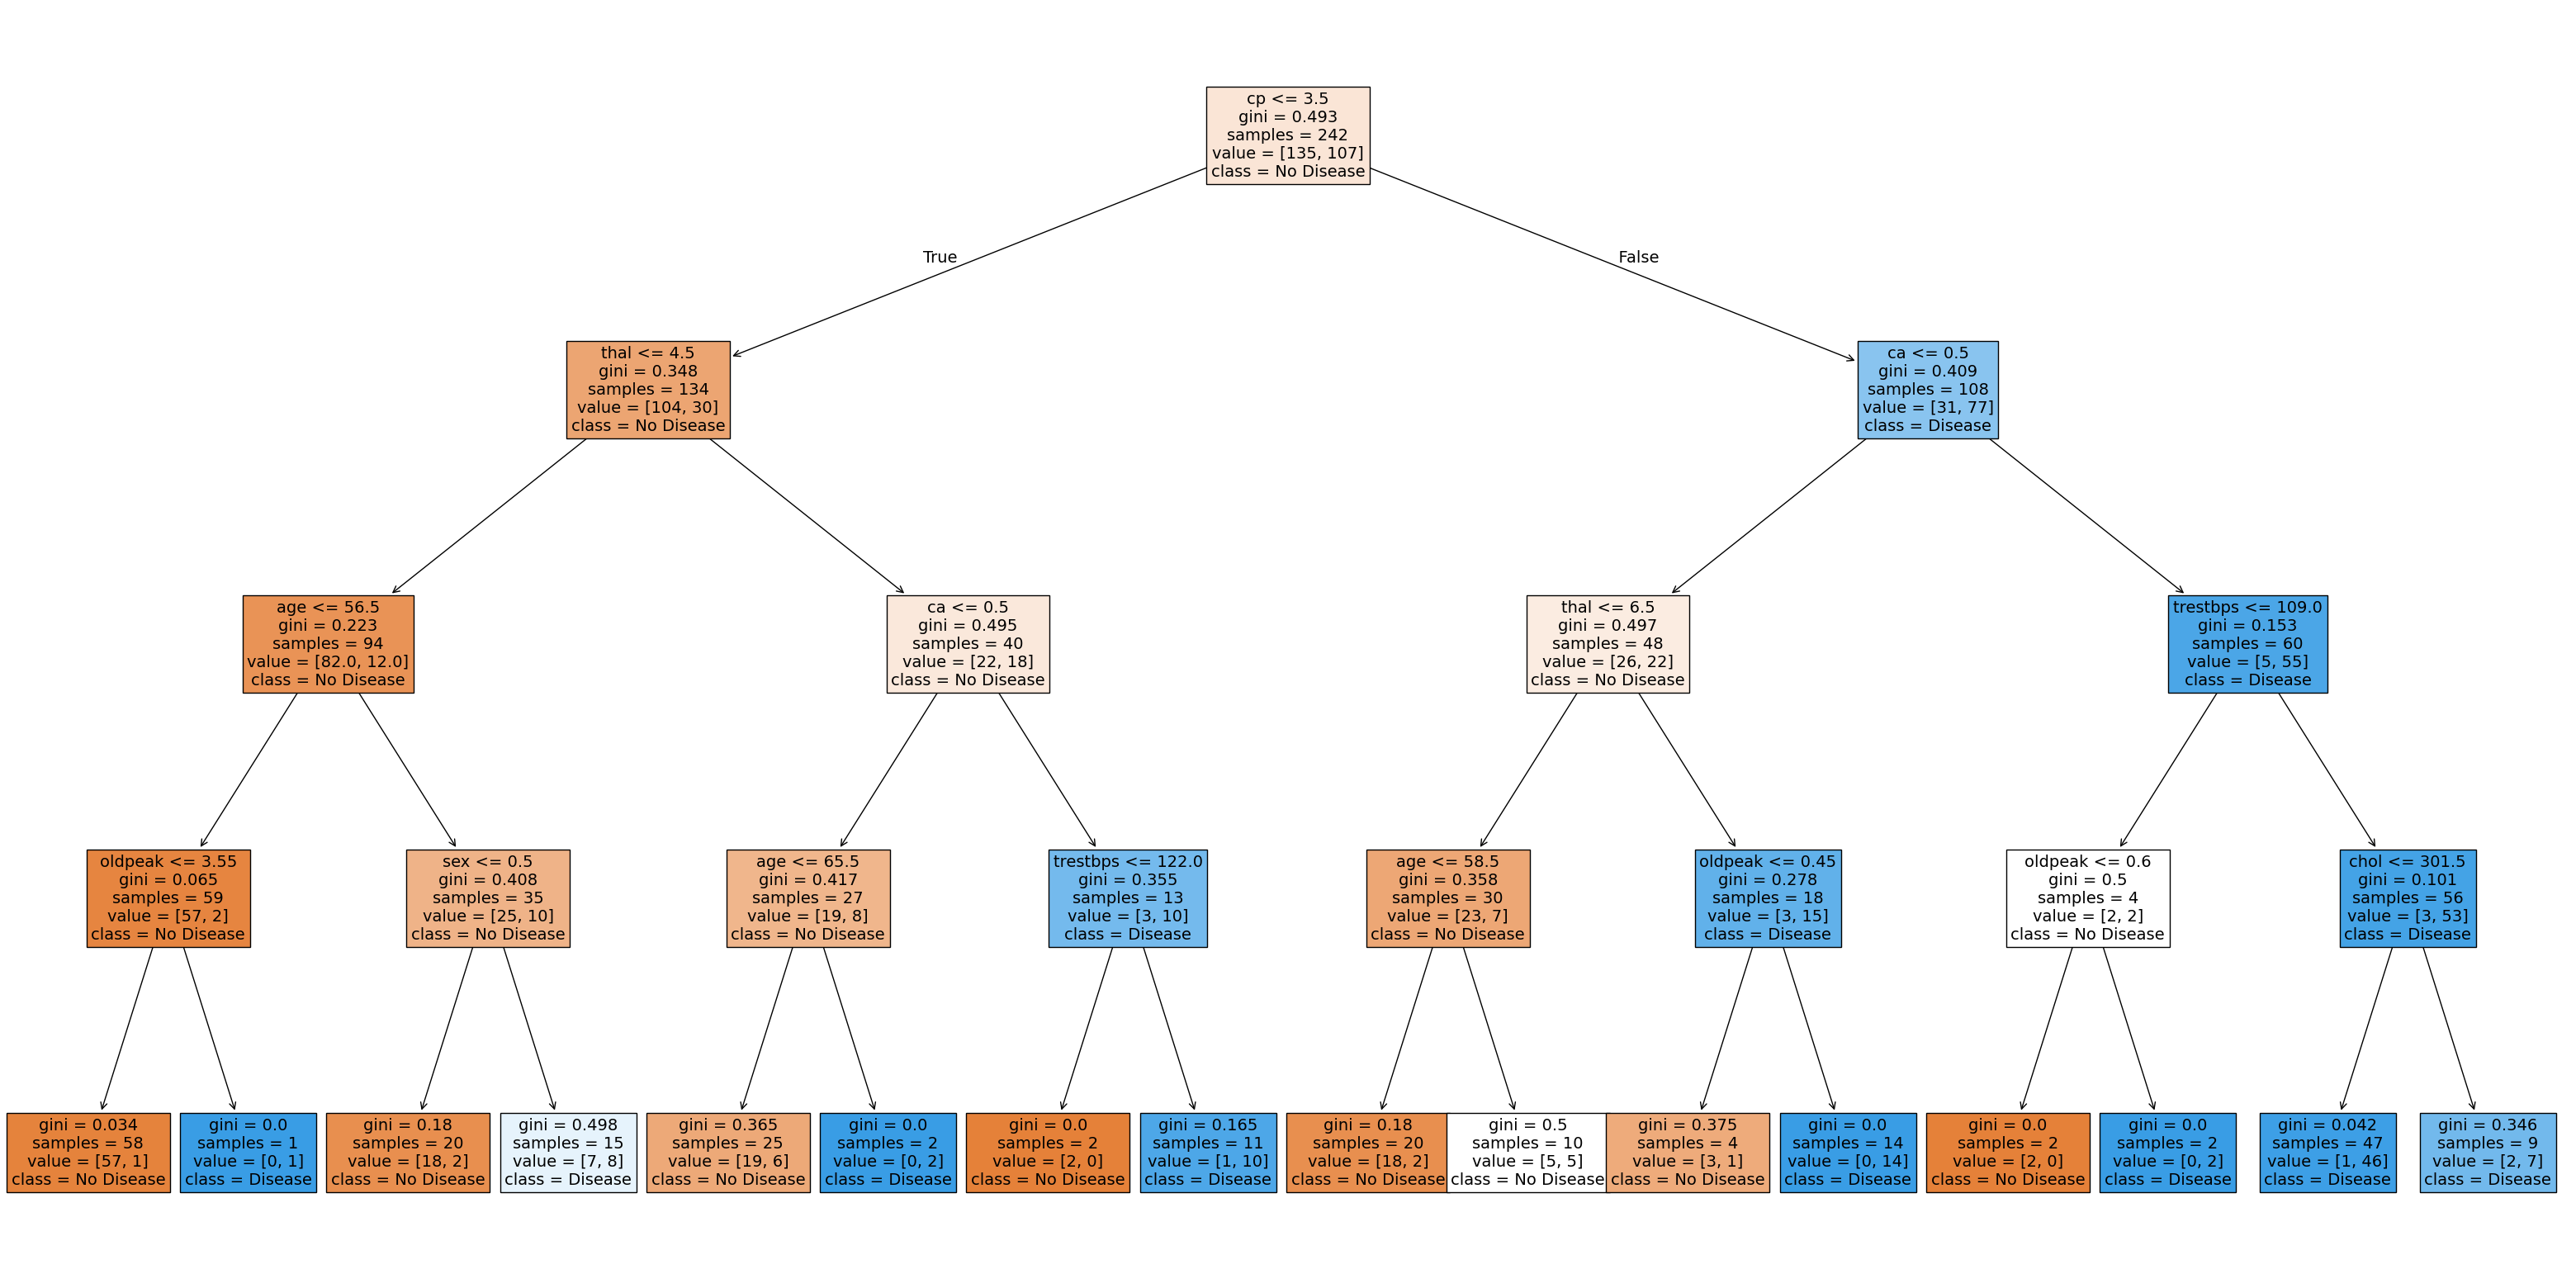

In [17]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

X = df.drop(['num'], axis=1)
y = (df['num'] > 0).astype(int)  # Binary classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

tree = DecisionTreeClassifier(max_depth = 4, random_state = 42)
tree.fit(X_train, y_train)

plt.figure(figsize = (40, 20))
plot_tree(tree, feature_names = X.columns, class_names = ['No Disease', 'Disease'], filled = True, fontsize = 14)
plt.show()

### Random Forest Model: Improved Non-Linear Learning

After identifying the limitations of Logistic Regression, we selected Random Forest as our next model due to its ability to capture complex, non-linear relationships between features. Unlike a single decision tree, Random Forest combines the predictions of multiple trees to reduce overfitting and improve generalization, making it a strong candidate for small-to-medium datasets like ours.

Performance metrics improved notably, particularly in recall and F1-score, which is critical for a healthcare setting where false negatives (missed diagnoses) carry significant risk. This improvement suggests that Random Forest was better able to model subtle interactions between features such as `cp`, `thalach`, `oldpeak`, and `ca`, all of which emerged as top predictors in our feature importance analysis. These findings also align with domain knowledge, lending credibility to the model's internal logic.

However, we observed some sensitivity to the random seed, indicating instability in predictions. Initially, we used default parameters, but later implemented GridSearchCV to fine-tune hyperparameters like `max_depth` and `n_estimators`. This tuning stabilized performance and improved consistency, though we acknowledge that Random Forest’s ensemble nature comes at the cost of reduced interpretability compared to Logistic Regression, a trade-off we deemed acceptable for improved clinical accuracy.

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



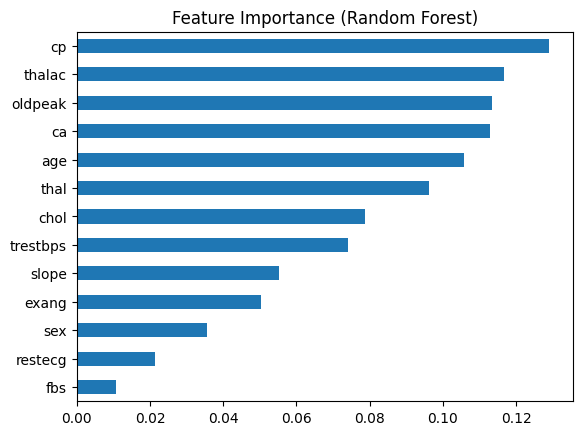

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))

importances = pd.Series(forest.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.show()

### XGBoost: Best Overall Performance

We chose to implement XGBoost after Random Forest because it builds on similar tree-based principles while introducing regularization and more granular control over model complexity. Its robustness to overfitting, ability to model complex feature interactions, and scalability made it a compelling option, even for a relatively small dataset like ours.

XGBoost ultimately delivered the best performance across all metrics, particularly accuracy and F1-score. This confirms its strength in managing bias-variance trade-offs and leveraging important predictors like `cp`, `thalach`, `oldpeak`, and `ca`, which repeatedly emerged as top contributors across models.

We encountered some challenges preprocessing categorical variables for compatibility with XGBoost, which does not natively handle non-numeric features. To address this, we applied one-hot encoding and adjusted key parameters (e.g., disabling `use_label_encoder`, setting `eval_metric` to `logloss`) in line with current best practices.

Contrary to earlier experiments with default parameters, we later applied both GridSearchCV and RandomizedSearchCV to fine-tune hyperparameters such as `max_depth`, `n_estimators`, and `learning_rate`. While GridSearchCV delivered slightly higher accuracy, RandomizedSearchCV was more efficient and likely to generalize better due to its broader search space.

To better interpret the model's predictions, we also incorporated SHAP analysis, which confirmed that the most influential features aligned with clinical expectations. Despite XGBoost's black-box reputation, this interpretability step made the model more transparent and trustworthy in a healthcare context.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:55:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



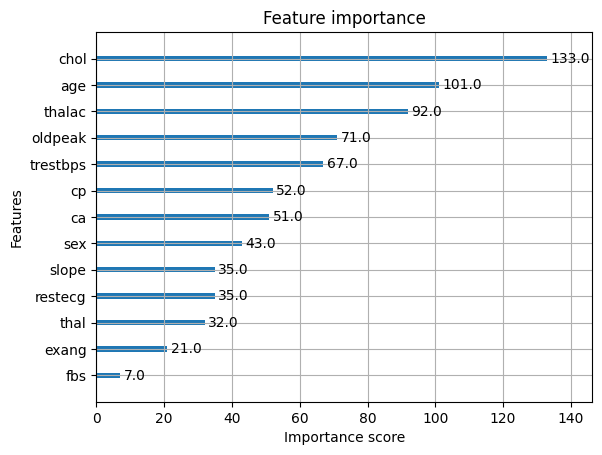

In [19]:
import xgboost as xgb

model = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

xgb.plot_importance(model)
plt.show()

### Hyperparameter Tuning: GridSearchCV vs. RandomizedSearchCV

To improve the performance and robustness of our XGBoost model, we implemented two hyperparameter optimization techniques: **GridSearchCV** and **RandomizedSearchCV**. Our goal was not only to improve metrics like F1-score but also to ensure stability and generalizability, which are essential in high-stakes domains like healthcare.

**GridSearchCV** exhaustively searched a predefined set of hyperparameters and identified the best combination as:
- `learning_rate`: 0.3  
- `max_depth`: 7  
- `n_estimators`: 100

This configuration yielded strong results:
- **Accuracy:** 0.87  
- **F1-Score:** 0.87 (macro & weighted average)

While effective, GridSearchCV is computationally expensive and limited to the values explicitly defined in the grid. It can miss better combinations that fall outside this narrow search space.

**RandomizedSearchCV**, in contrast, sampled 50 random combinations from a broader parameter distribution. It identified the following optimal configuration:
- `colsample_bytree`: 0.916  
- `learning_rate`: 0.095  
- `max_depth`: 6  
- `n_estimators`: 70  
- `subsample`: 0.809

Performance was slightly lower but still strong:
- **Accuracy:** 0.85  
- **F1-Score:** 0.85 (macro & weighted average)

Although GridSearchCV produced marginally higher scores, RandomizedSearchCV was more computationally efficient and better suited for exploratory tuning when time and resources are constrained. Importantly, it may yield models that generalize better to unseen data.

Ultimately, using both methods gave us a more complete understanding of how hyperparameters affect performance, and underscored the importance of tuning in unlocking the full potential of ensemble models like XGBoost.

In [20]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Initialize model
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Predict using the best model
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report
print("Classification Report for Tuned XGBoost:")
print(classification_report(y_test, y_pred_xgb))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100}
Classification Report for Tuned XGBoost:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [21]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# Define the parameter distributions
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.4),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

# Initialize model
xgb_clf = XGBClassifier(random_state=42, eval_metric='logloss')

# Run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,  # number of random combinations to try
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the search
random_search.fit(X_train, y_train)

xgb_random_best = random_search.best_estimator_

# Print best results
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)
y_pred = random_search.predict(X_test)
print("\nClassification Report for Tuned XGBoost (RandomizedSearchCV):")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters from RandomizedSearchCV: {'colsample_bytree': 0.9162213204002109, 'learning_rate': 0.09493564427131046, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.8087407548138583}

Classification Report for Tuned XGBoost (RandomizedSearchCV):
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



### SHAP Feature Importance Analysis

To interpret the predictions made by our tuned XGBoost model, we used **SHAP (SHapley Additive exPlanations)** — a powerful interpretability technique grounded in cooperative game theory. SHAP assigns each feature an importance value for a given prediction, allowing us to understand not just what the model predicted, but why.

- The **summary plot (beeswarm)** illustrates how individual features influenced predictions across all samples. Each point represents a SHAP value, with color indicating the original feature value (red = high, blue = low). For example, high values of `'cp'` (chest pain type) and `'thal'` (thalassemia) were associated with increased heart disease risk, while high values of `'ca'` (number of major vessels) were linked to decreased risk.
  
- The **bar plot** shows the **mean absolute SHAP value** of each feature, ranking them by their average impact. Consistent with our earlier models, `'ca'`, `'cp'`, and `'thal'` were the most influential features.

This analysis is especially valuable in a healthcare context, where black-box models can be difficult to trust. SHAP improves transparency and provides clinicians with a clearer picture of what the model prioritizes when making decisions. It also supports clinical validation by reinforcing the medical relevance of key features. 

However, while SHAP helps us interpret model behavior, it does not uncover dataset bias or structural issues. Still, its ability to explain individual predictions makes it a critical step toward deploying machine learning responsibly in sensitive domains like cardiovascular risk prediction.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


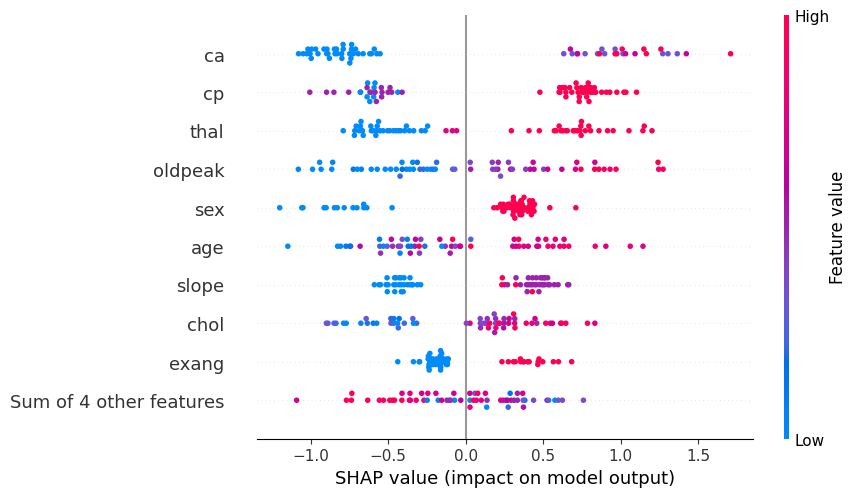

In [22]:
import shap
import matplotlib.pyplot as plt

# Create a TreeExplainer for the best model from RandomizedSearchCV
explainer = shap.Explainer(xgb_random_best)

# Compute SHAP values
shap_values = explainer(X_test)

# Plot summary plot
shap.plots.beeswarm(shap_values)


### Model Comparison and Reflection

Throughout this project, we evaluated multiple models to predict heart disease risk, balancing interpretability and predictive performance. Logistic Regression served as our baseline and offered straightforward insights into feature impact, but it underperformed on recall and F1-score, making it less reliable for clinical application.

Tree-based models like Random Forest and XGBoost provided notable improvements. Random Forest captured non-linear relationships effectively, while XGBoost delivered the strongest overall performance, achieving an F1-score of 0.87 after hyperparameter tuning via GridSearchCV and 0.85 using RandomizedSearchCV. Both tuning methods validated that careful optimization meaningfully improves model outcomes, with RandomizedSearchCV offering faster, broader exploration.

We also used SHAP to interpret the tuned XGBoost model’s predictions. SHAP revealed that features like chest pain type (cp), number of major vessels (ca), and thalassemia (thal) had the greatest impact on classification decisions. This alignment with known medical knowledge confirms the model is learning relevant patterns rather than spurious correlations.

Despite strong results, limitations persist. The dataset is relatively small (303 samples), which affects generalizability. Cross-validation helped mitigate overfitting, but real-world deployment would require validation on external datasets. Future work should also explore ensemble approaches, deeper hyperparameter search (e.g., with Optuna), and integration into a clinical decision-support tool.